In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
r = pd.read_csv('../../Data/rejected.csv')
r.head(2)

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0


In [4]:
dictionary = pd.read_excel('../../Data/LCDataDictionary.xlsx')
dictionary

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


In [5]:
data = pd.read_csv('../../Data/Combo_3_DropNAs.csv')
data.shape

(11091453, 4)

In [6]:
data.head(2)

,Risk_Score,DI,Employment Length,Accepted
0,0.411783,-0.008441,2.668416,1
1,0.871415,-0.007807,2.668416,1


In [7]:
data = data.rename(columns={"Risk_Score":"FICO Score", "DI":"Debt-To-Income Ratio"})
data.head(2)

,FICO Score,Debt-To-Income Ratio,Employment Length,Accepted
0,0.411783,-0.008441,2.668416,1
1,0.871415,-0.007807,2.668416,1


In [8]:
X = data.drop('Accepted', axis=1)
X.shape

(11091453, 3)

In [9]:
y = data['Accepted']

In [10]:
lgbclf = lgb.LGBMClassifier()

In [11]:
steps = [('model', lgbclf)]
pipeline = Pipeline(steps=steps)

In [12]:
#Accuracy with "X", no scaling:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.97409312 0.97381227 0.97419004 0.97430453 0.97451415]
0.9741828235176255


In [13]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[8879581,   98228],
       [ 188122, 1925522]])

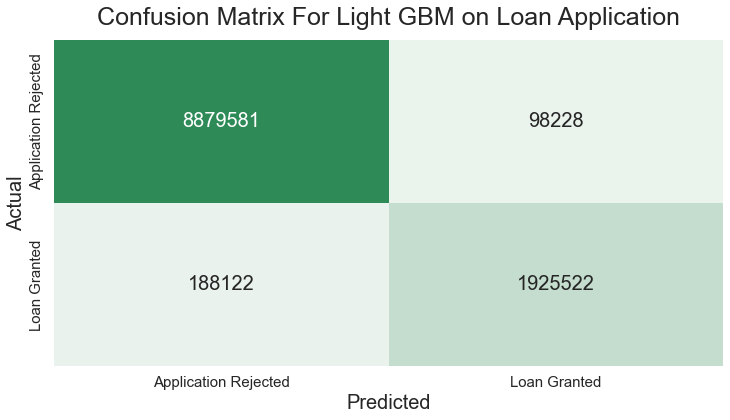

In [14]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Application Rejected', 'Loan Granted'], fontsize=15)
res.set_yticklabels(['Application Rejected', 'Loan Granted'], fontsize=15)


plt.title('Confusion Matrix For Light GBM on Loan Application', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [15]:
accuracy_score(y, y_pred)

0.9741828234767799

In [16]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

1925522
98228
188122
8879581
0.9741828234767799


In [17]:
#Re-examine original pool of Applications: 

print(data.Accepted.value_counts())
#0 = Application Rejected
#1 = Loan Granted

accepted_loan = data.Accepted.value_counts()[1]
rejected_loan = data.Accepted.value_counts()[0]

print()
print(rejected_loan / (accepted_loan + rejected_loan))

#Random investment would give us 80% chance of pickkng a rejected loan

0    8977809
1    2113644
Name: Accepted, dtype: int64

0.8094348864842145


In [18]:
lgbclf.fit(X,y)

LGBMClassifier()

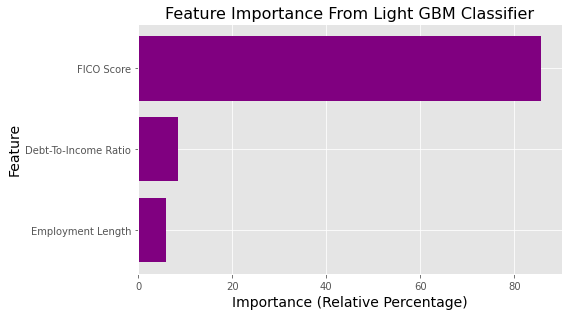

In [19]:
plt.figure(figsize=(8,4.5))
plt.style.use('default')
plt.style.use('ggplot')

feature_importances = (lgbclf.feature_importances_ / sum(lgbclf.feature_importances_)) * 100

sorted_idx = np.argsort(feature_importances)
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center', color='purple')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance From Light GBM Classifier', fontsize=16, color='black')
plt.xlabel('Importance (Relative Percentage)', fontsize=14, color='black')
plt.ylabel('Feature', fontsize=14, color='black')

plt.tight_layout()
plt.show();


In [20]:
feature_importances

array([85.76666667,  8.4       ,  5.83333333])